In [1]:
import os
os.chdir('../app')

In [2]:
import frontend.stock_analytics as salib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from datetime import datetime,timedelta
from pprint import pprint
import matplotlib.patches as patches
import time
import numpy as np
import datetime
import copy
import preprocessing.lob.s03_fill_cache as l03
import re
import preprocessing.preglobal as pg
%matplotlib inline
import fit_lib as fl

/opt/conda/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [3]:
import analysis_lib as al

In [4]:
import task_lib as tl

In [5]:
import scipy

In [6]:
import cv2
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from pymongo import MongoClient, UpdateMany, UpdateOne, InsertOne
import pandas as pd

In [7]:
import json

In [8]:
# from json
with open("all_results_w_frac.json", "r") as out_file:
    all_results_w_frac_json = json.load(out_file)

In [9]:
all_results_w_frac = {}
for k,v in all_results_w_frac_json.items():
    all_results_w_frac[k] = pd.DataFrame(v)

In [10]:
# flatten it
all_results_flat = pd.DataFrame()
for k,v in all_results_w_frac.items():
    v['keynote'] = k
    all_results_flat = all_results_flat.append(v)

In [11]:
pd.set_option('display.max_rows', 500)

In [13]:
filtered2 = all_results_flat[all_results_flat['frac_of_total150'] > 0.65]

In [14]:
filtered = all_results_flat[[not pd.isna(a) and ('iphone' in a.lower() or 'ipad' in a.lower()) and ('neu' in a.lower()) 
                             for a in all_results_flat['metadata'] ]].sort_values("frac_of_total150", ascending=False)

In [15]:
len(filtered2)

88

In [16]:
knotes = pg.get_kn_entries({'selected':1})

mongo mongodb://192.168.0.94:27017/


In [ ]:
for _,v in filtered2.iterrows():
    selected = [kn for kn in knotes if kn['id'] == v['keynote']][0]
    dt1 = 16*60*1000
    dt2 = 16*60*1000
    ttrans = v['time']*1000 + selected['time_mapping'][0]['stock_time_start']
    
    print(v['keynote']+' '+v['text'])
    
    fit_task = {    'task':'fit',
         'method':'mle_extended',
         'start': ttrans-dt1,
         'stop': ttrans+dt2,
         'id':v['keynote'],
         't_0':dt1/1000,
        'dtbound':120,
         'stock_t_0': ttrans,
          'video_t_0':v['time'] ,
         'origin': v.to_dict()
    }
    #tl.add_task(fit_task)

In [18]:
tl.execute_tasks()

In [20]:
# CREATE SIMULATION FOR MOMENT OR MLE FIT RESULTS - IF NOT ALREADY SIMULATED

tbl = tl.dbconnect()
tasks = list(
        tbl.aggregate([{"$match":{"status":{"$in":[2,3]},"error":None}},{"$sort":{"task.id":1}}], allowDiskUse=True)
    )

c = 0
for i in tasks:
    if 'method' not in i['task']:
        continue
    if len([t for t in tasks if 'origin' in t['task'] and t['task']['task'] == 'simulate' and t['task']['origin']['id'] == i['_id']]) > 0:
        continue
    

    if i['task']['method'] == 'mle_extended':
        task = {'origin':{'id':i['_id'], 'task':i['task']}, 'task':'simulate', 'id':i['task']['id'], 'start':i['task']['start'], 'stop':i['task']['stop'],
               'phi_dash':i['result']['first_part']['phi_dash'],
        'g_params':i['result']['first_part']['g_params'],
        'news_params': [i['result']['news_params']],
               }
        
        print(task)
        c+=1
        #tl.add_task(task)
print(c)

0


In [24]:
tbl = tl.dbconnect()
tasks = list(
        tbl.aggregate([{"$match":{"status":3,"error":None,'task.task':'simulate','task.origin.task.method':'mle_extended'}},{"$sort":{"task.id":1}}])
    )

In [26]:
len(tasks)

88

In [64]:
results = {}

for t in tasks:
    t0 = t['task']['origin']['task']['t_0']
    assert t0 == 960.
     
    results[key] = {
        'g_params':t['task']['g_params'],
        'news_params':t['task']['news_params'],
        'task':t,
         'filter':{"status":3,"error":None,
                              "task.origin.task.origin.text":t['task']['origin']['task']['origin']['text'],
                              "task.origin.task.origin.src":t['task']['origin']['task']['origin']['src'],
                              "task.id":t['task']['id'],
                             }
    }

        

In [59]:
plt.rcParams['figure.figsize'] = (15, 5)

In [60]:
g_params = np.array([v["g_params"] for _,v in results.items()])

In [65]:
news_params = np.array([v["news_params"][0] for _,v in results.items()])
news_params[:,0] = news_params[:,0]-t0

In [66]:
print('g_params',g_params.mean(axis=0),'+/-',g_params.std(axis=0))

g_params [7.45628929e-01 4.01635345e+03 6.04479131e-01] +/- [1.41998679e-02 1.98795161e+02 8.80561319e-02]


In [67]:
print('news_params',news_params.mean(axis=0),'+/-',news_params.std(axis=0))

news_params [4.89145710e+01 3.26959966e+00 4.85956289e-03] +/- [2.10792646e+01 1.81920399e+00 5.88920829e-03]


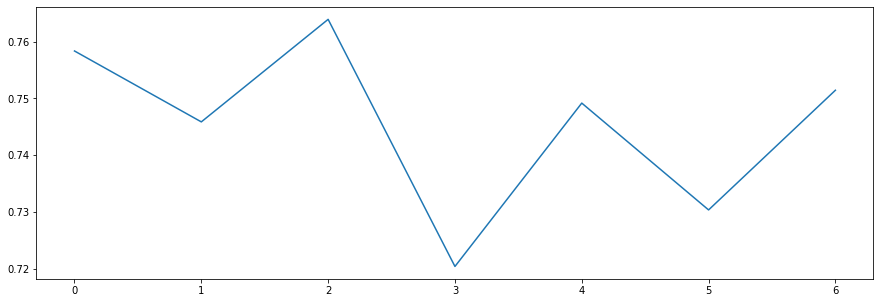

In [49]:
plt.plot([v["g_params"][0] for _,v in results.items()])

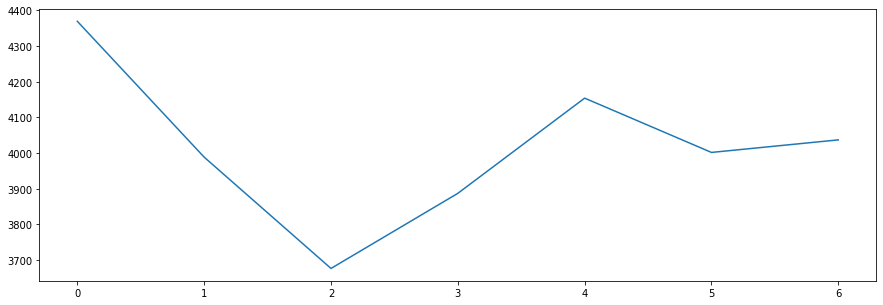

In [50]:
plt.plot([v["g_params"][1] for _,v in results.items()])

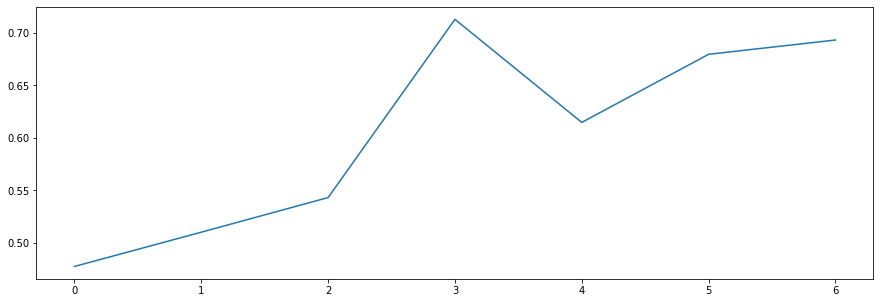

In [51]:
plt.plot([v["g_params"][2] for _,v in results.items()])

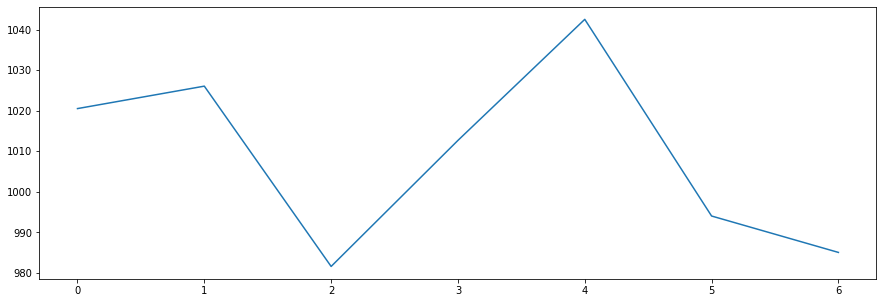

In [52]:
plt.plot([v["news_params"][0][0] for _,v in results.items()])

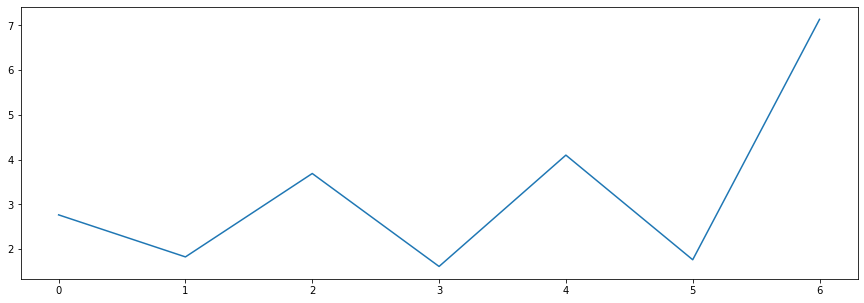

In [53]:
plt.plot([v["news_params"][0][1] for _,v in results.items()])

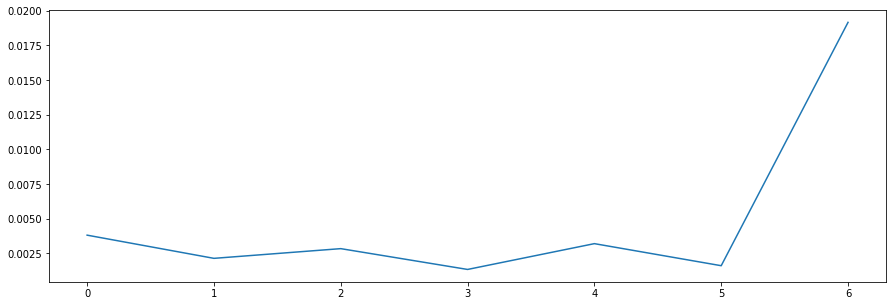

In [54]:
plt.plot([v["news_params"][0][2] for _,v in results.items()])

In [56]:
folder = "Thesis/generated_figures/"

$99 {"GLEICHER FRAME": {"14": ""}, "News": {"14": "alt"}, "Produkt": {"14": "Apple TV (alter Preis)"}, "knid": {"14": 1}, "price": {"14": "99"}, "triggerid": {"14": 1.0}}
{'status': 3, 'error': None, 'task.origin.task.origin.text': '$99', 'task.origin.task.origin.src': 'numbers_ocr', 'task.id': '20150309_AAPL'}
redis 192.168.0.94
(1) V = 279.296975 ; E = 13.555 ; V/E = 20.604719660641827
(2) V = 1254.9975000000002 ; E = 26.95 ; V/E = 46.56762523191095
V = 812.00374375 ; E = 20.2525 ; V/E = 40.094000432045426
(1) V = 152.0719 ; E = 13.59 ; V/E = 11.189985283296542
(2) V = 625.7277750000001 ; E = 26.915 ; V/E = 23.24829184469627
V = 433.2887437500001 ; E = 20.2525 ; V/E = 21.39433372423158


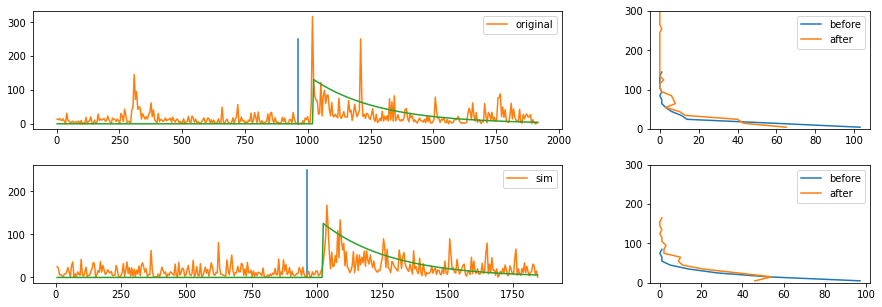

baseball nan
{'status': 3, 'error': None, 'task.origin.task.origin.text': 'baseball', 'task.origin.task.origin.src': 'keyword_ocr', 'task.id': '20150909_AAPL'}
redis 192.168.0.94
(1) V = 499.63 ; E = 20.2 ; V/E = 24.734158415841584
(2) V = 698.2619750000001 ; E = 34.945 ; V/E = 19.981742023179287
V = 653.29974375 ; E = 27.5725 ; V/E = 23.693888611841505
(1) V = 312.98040000000003 ; E = 20.64 ; V/E = 15.163779069767443
(2) V = 328.3911 ; E = 31.67 ; V/E = 10.369153773287021
V = 351.10097500000006 ; E = 26.155 ; V/E = 13.42385681514051


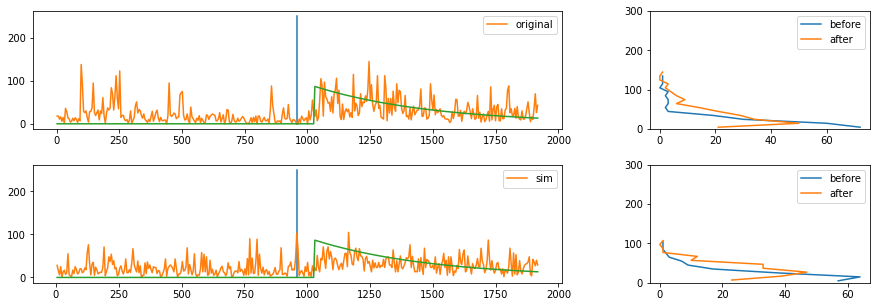

$799 {"GLEICHER FRAME": {"10": ""}, "News": {"10": "NEU"}, "Produkt": {"10": "iPhone 8 Plus"}, "knid": {"10": 0}, "price": {"10": "799"}, "triggerid": {"10": 9.0}}
{'status': 3, 'error': None, 'task.origin.task.origin.text': '$799', 'task.origin.task.origin.src': 'numbers_ocr', 'task.id': '20170912_AAPL'}
redis 192.168.0.94
(1) V = 770.0636000000002 ; E = 31.92 ; V/E = 24.12479949874687
(2) V = 2763.6179750000006 ; E = 67.705 ; V/E = 40.81852115796471
V = 2086.98234375 ; E = 49.8125 ; V/E = 41.89675972396487
(1) V = 438.1575 ; E = 29.65 ; V/E = 14.777655986509277
(2) V = 988.4975 ; E = 56.75 ; V/E = 17.418458149779735
V = 896.93 ; E = 43.2 ; V/E = 20.762268518518518


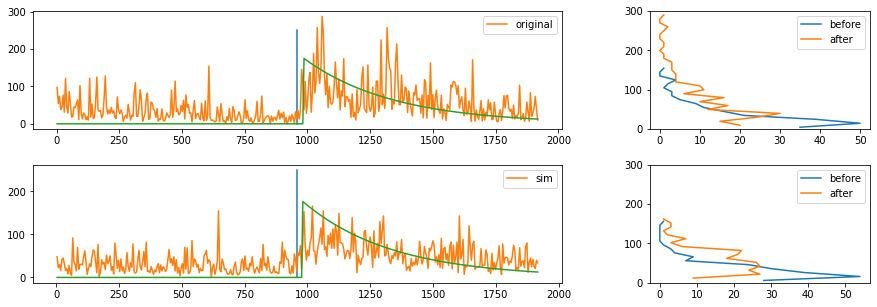

$999 {"GLEICHER FRAME": {"51": ""}, "News": {"51": "NEU"}, "Produkt": {"51": "iPhone 11 Pro"}, "knid": {"51": 3}, "price": {"51": "999"}, "triggerid": {"51": 10.0}}
{'status': 3, 'error': None, 'task.origin.task.origin.text': '$999', 'task.origin.task.origin.src': 'numbers_ocr', 'task.id': '20190910_AAPL'}
redis 192.168.0.94
(1) V = 331.9475 ; E = 19.65 ; V/E = 16.893002544529264
(2) V = 2513.3857749999997 ; E = 46.315 ; V/E = 54.267208787649786
V = 1600.42219375 ; E = 32.9825 ; V/E = 48.523374327294775
(1) V = 221.540975 ; E = 20.155 ; V/E = 10.991861820888117
(2) V = 424.8175 ; E = 34.05 ; V/E = 12.476284875183554
V = 371.44699375 ; E = 27.1025 ; V/E = 13.705266811179781


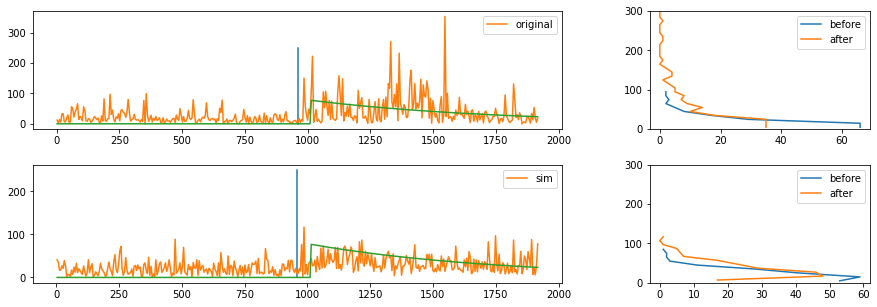

iPad mini nan
{'status': 3, 'error': None, 'task.origin.task.origin.text': 'iPad mini', 'task.origin.task.origin.src': 'keyword_subs', 'task.id': '20190910_AAPL'}
redis 192.168.0.94
(1) V = 687.9599000000001 ; E = 24.49 ; V/E = 28.091461821151494
(2) V = 3796.466975000001 ; E = 57.555 ; V/E = 65.96241812179656
V = 2515.5369937500004 ; E = 41.0225 ; V/E = 61.32090910475959
(1) V = 382.03960000000006 ; E = 24.02 ; V/E = 15.905062447960036
(2) V = 961.5328333457094 ; E = 47.472636815920396 ; V/E = 20.25446442071763
V = 810.0144650841723 ; E = 35.775561097256855 ; V/E = 22.64155865737858


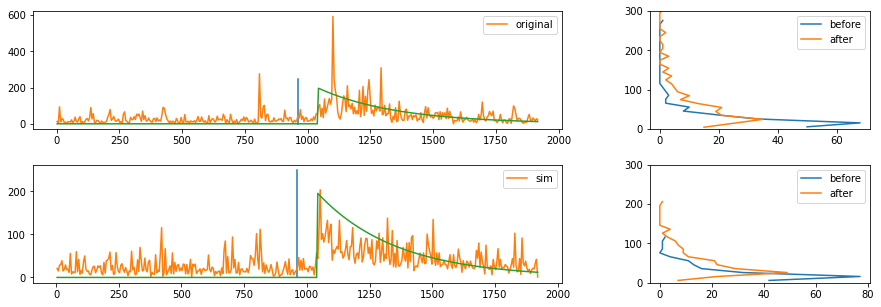

$449 {"GLEICHER FRAME": {"47": ""}, "News": {"47": "alt"}, "Produkt": {"47": "iPhone 8"}, "knid": {"47": 3}, "price": {"47": "449"}, "triggerid": {"47": 6.0}}
{'status': 3, 'error': None, 'task.origin.task.origin.text': '$449', 'task.origin.task.origin.src': 'numbers_ocr', 'task.id': '20190910_AAPL'}
redis 192.168.0.94
(1) V = 412.4119 ; E = 20.41 ; V/E = 20.20636452719255
(2) V = 2097.4651 ; E = 45.43 ; V/E = 46.169163548316085
V = 1411.4386 ; E = 32.92 ; V/E = 42.87480558930741
(1) V = 259.1056 ; E = 19.88 ; V/E = 13.03348088531187
(2) V = 408.3111 ; E = 36.17 ; V/E = 11.288667403925905
V = 400.049375 ; E = 28.025 ; V/E = 14.274732381801963


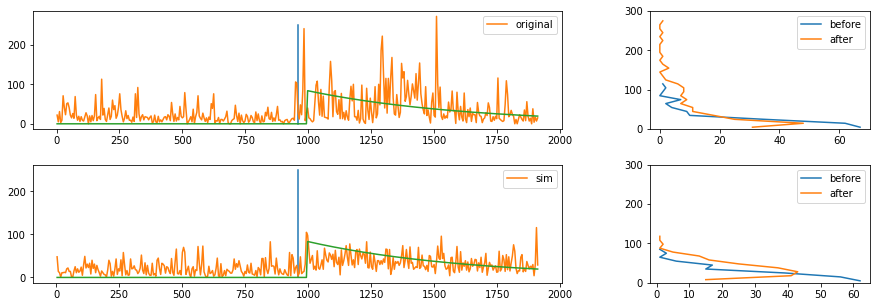

$699 {"GLEICHER FRAME": {"50": ""}, "News": {"50": "NEU"}, "Produkt": {"50": "iPhone 11"}, "knid": {"50": 3}, "price": {"50": "699"}, "triggerid": {"50": 9.0}}
{'status': 3, 'error': None, 'task.origin.task.origin.text': '$699', 'task.origin.task.origin.src': 'numbers_ocr', 'task.id': '20190910_AAPL'}
redis 192.168.0.94
(1) V = 547.827975 ; E = 30.455 ; V/E = 17.988112789361356
(2) V = 3424.0527749999997 ; E = 44.415 ; V/E = 77.09226106045254
V = 2034.660775 ; E = 37.435 ; V/E = 54.35183050621076
(1) V = 405.8196 ; E = 27.02 ; V/E = 15.019230199851961
(2) V = 836.410975 ; E = 37.595 ; V/E = 22.2479312408565
V = 649.0729437499999 ; E = 32.3075 ; V/E = 20.0904726069798


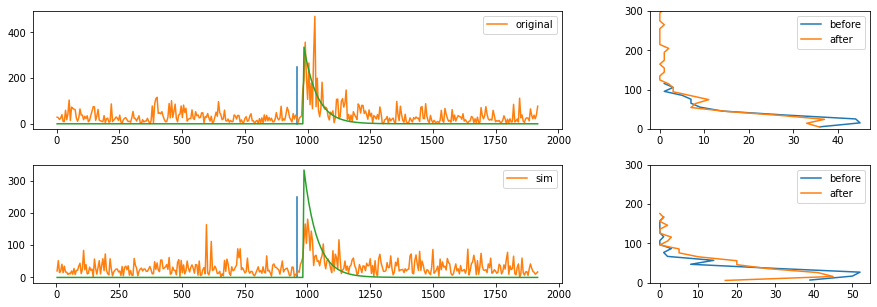

In [58]:
fignr = 0
for k,v in results.items():
    print(k)
    print(v['filter'])
    result_sim = v['task']["result"]
    sim_results = np.array(result_sim['sim_results'])
    task_sim = v['task']['task']

    original_data = fl.load_data(task_sim)
    sim_results_cutted = sim_results[sim_results <= original_data[-1]]

    ats_array = [('original',original_data), ('sim',sim_results_cutted)]

    # c

    tau = np.logspace(-3,2,20)
    N=400
    splitpoint=None
    stepsize_hist=2.

    if len(ats_array) > 20:
        ats_array = [ats_array]

    plt.rcParams['figure.figsize'] = (15, 5)
    fig = plt.figure()
    grid = plt.GridSpec(2, 3, wspace=0.4, hspace=0.3)

    row = 0
    for kts_array in ats_array:
        if type(kts_array) is tuple:
            ts_array = kts_array[1]
            label = kts_array[0]
        else:
            ts_array = kts_array


        plt.subplot(grid[row, 0:2])
        midp = task_sim['origin']['task']['t_0']
        plt.plot([midp, midp],[0,250])
        x_bins, y_bins, _ = al.dobins(ts_array, N = N)
        plt.plot(x_bins, y_bins, label=label)
        plt.legend()

        x_bins_news = x_bins[x_bins > task_sim['news_params'][0][0]]
        y_bins_news_frac = task_sim['news_params'][0][1]*np.exp(-task_sim['news_params'][0][2]*(x_bins_news-task_sim['news_params'][0][0]))
        y_bins_news = np.zeros(len(x_bins))
        y_bins_news[x_bins > task_sim['news_params'][0][0]] =10*(x_bins[1]-x_bins[0])*y_bins_news_frac

        plt.plot(x_bins, y_bins_news)


        plt.subplot(grid[row, 2])

        splitpoint = 0.5
        stepsize_hist= 10.
        if splitpoint is not None:
            y_bins1 = y_bins[:int(splitpoint*len(y_bins))]
            y_bins2 = y_bins[int(splitpoint*len(y_bins)):]
            a_bins1, b_bins1, _ = al.dobins(y_bins1, useinteger=True, stepsize=stepsize_hist)
            a_bins2, b_bins2, _ = al.dobins(y_bins2, useinteger=True, stepsize=stepsize_hist)
            plt.plot(b_bins1, a_bins1, label='before')
            plt.plot(b_bins2, a_bins2, label='after')
            plt.legend()
            print('(1) V =',y_bins1.var(),'; E =',y_bins1.mean(),'; V/E =', y_bins1.var()/y_bins1.mean())
            print('(2) V =',y_bins2.var(),'; E =',y_bins2.mean(),'; V/E =', y_bins2.var()/y_bins2.mean())
        else:
            a_bins, b_bins, _ = al.dobins(y_bins, useinteger=True, stepsize=stepsize_hist)
            plt.plot(b_bins, a_bins, label=label)
        plt.ylim(0, 300)

        print('V =',y_bins.var(),'; E =',y_bins.mean(),'; V/E =', y_bins.var()/y_bins.mean())

        row+=1
    plt.show()
    fig.savefig(folder+"res_lob_anhang"+str(fignr)+".pdf")
    fignr+=1